# Importações e funções auxiliares para leitura de dados do laser

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import time
import matplotlib.image as mpimg
import networkx as nx

from shapely.geometry import Point
from shapely.geometry import LineString
from shapely.geometry import Polygon

from descartes.patch import PolygonPatch

try:
    import sim
except:
    print ('--------------------------------------------------------------')
    print ('"sim.py" could not be imported. This means very probably that')
    print ('either "sim.py" or the remoteApi library could not be found.')
    print ('Make sure both are in the same folder as this file,')
    print ('or appropriately adjust the file "sim.py"')
    print ('--------------------------------------------------------------')
    print ('')

class LaserData:
    dist = 0
    angle = 0
    x = 0
    y = 0
    
    def __init__(self,distance,angle_beam,x_obs,y_obs):
        self.dist = distance
        self.angle = angle_beam
        self.x = x_obs
        self.y = y_obs

    
# Retorna um vetor com duas colunas: [angulo, dist]
def format_laser_data(clientID):
    laser_data=[]
    returnCodeRanges, string_range_data = sim.simxGetStringSignal(clientID, "hokuyo_range_data", sim.simx_opmode_streaming)
    returnCodeAngles, string_angle_data = sim.simxGetStringSignal(clientID, "hokuyo_angle_data", sim.simx_opmode_blocking)
    if returnCodeRanges == 0 and returnCodeAngles == 0:
        # unpack data from range and sensor messages
        raw_range_data = sim.simxUnpackFloats(string_range_data)
        raw_angle_data = sim.simxUnpackFloats(string_angle_data)
        #calculate x,y coordinates of an obstacle based on beam distance and angle
        for i in range(len(raw_range_data)):
            x = (raw_range_data[i]*np.cos(raw_angle_data[i]))
            y = (raw_range_data[i]*np.sin(raw_angle_data[i]))

            data = LaserData(raw_range_data[i], raw_angle_data[i], x, y)
            laser_data.append(data)
        return laser_data

    # return none in case were nothing was gotten from the simulator
    return None

def Rz(theta):
    return np.array([[  np.cos(theta), np.sin(theta),  0],
                      [ -np.sin(theta), np.cos(theta),  0],
                      [ 0,             0,              1]])


# Campos Potenciais - Robô não holonômico (Pioneer)
Abra a cena mapa_2_potentialfield.ttt no Coppelia e execute o bloco a seguir:

In [ ]:
def calcAttractiveForce(pos, target, k_a):
    dx = target[0]-pos[0]
    dy = target[1]-pos[1]
    rho = np.array([dx,dy])
    norm_rho = np.sqrt(dx**2 + dy**2)

    #maximum velocity
    if(norm_rho) <= 0.5:
        attr_force = k_a*rho
    else:
        attr_force = k_a*rho/norm_rho
    return attr_force

def calcRepulsiveForce(laser_data, k_r):
    rep_force = np.array([0,0])
    for item in laser_data:
        dir(item)
        dist = item.dist
        angle = item.angle
        x = item.x
        y = item.y
        
        #distância máxima pra considerar a força de um obstaculo
        if dist <= 1.0:
            fx = k_r*(1/(dist**2))
            fy = k_r*(1/(dist**2))
            print("fx",fx, "fy ",fy)
            #rep_force[0] = rep_force[0] - fx
            #rep_force[1] = rep_force[1] - fy
            rep_force[0] = -fx
            rep_force[1] = -fy
    return rep_force

print ('Program started')
sim.simxFinish(-1) # just in case, close all opened connections
clientID=sim.simxStart('127.0.0.1',19999,True,True,5000,5) # Connect to CoppeliaSim

if clientID!=-1:
    print ('Connected to remote API server')

    # Handle para o ROBÔ    
    robotname = 'Pioneer_p3dx'
    returnCode, robotHandle = sim.simxGetObjectHandle(clientID, robotname, sim.simx_opmode_oneshot_wait)     
    
    # Handle para as juntas das RODAS
    returnCode, l_wheel = sim.simxGetObjectHandle(clientID, robotname + '_leftMotor', sim.simx_opmode_oneshot_wait)
    returnCode, r_wheel = sim.simxGetObjectHandle(clientID, robotname + '_rightMotor', sim.simx_opmode_oneshot_wait)    
    
    # Handle para os dados do LASER
    laser_data_name = "hokuyo_range_data"
    
    # Geralmente a primeira leitura é inválida (atenção ao Operation Mode)
    # Em loop até garantir que as leituras serão válidas
    returnCode = 1
    while returnCode != 0:
        returnCode, range_data = sim.simxGetStringSignal(clientID, laser_data_name, sim.simx_opmode_streaming + 10)
    
    # Prosseguindo com as leituras
    laser_data = format_laser_data(clientID)    

    returnCode, pos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)        
    
    #raise SystemExit()
    
    # Dados do Pioneer
    L = 0.381   # Metros
    r = 0.0975  # Metros

    t = 0
    # Lembrar de habilitar o 'Real-time mode'
    startTime=time.time()
    lastTime = startTime
    
    
    #target = (16,19) #mapa2
    #target = (-8.5,0) #mapa3
    target = (-3, 1.5) #cave
    k_a = 1.0
    k_r = 1.0
    d = 0.5 #parâmetro d feedback (Desai et. al 1998)
    
    kv = 0.1
    kw = 0.1
    
    while t < 60:
        
        now = time.time()
        dt = now - lastTime
        returnCode, pos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
        returnCode, ori = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
        # Fazendo leitura do laser       
        print("ori",ori[2])
        laser_data = format_laser_data(clientID)
        
        #Calcula as forças atrativas e repulsivas
        attr_force = calcAttractiveForce(pos, target, k_a)
        repulsive_force = calcRepulsiveForce(laser_data, k_r)
        resulting_force  = attr_force + repulsive_force
        print("Attractive: ", attr_force,"Repulsive: ",repulsive_force)
        
        x_dot = resulting_force[0]
        y_dot = resulting_force[1]
        
        v = kv*(x_dot*np.cos(ori[2])+y_dot*np.sin(ori[2]))
        w = kw*(-(np.sin(ori[2])/d)*x_dot + (np.cos(ori[2])/d)*y_dot)
        
        wl = v/r - (w*L)/(2*r)
        wr = v/r + (w*L)/(2*r)
        
        # Enviando velocidades
        sim.simxSetJointTargetVelocity(clientID, l_wheel, wl, sim.simx_opmode_streaming + 5)
        sim.simxSetJointTargetVelocity(clientID, r_wheel, wr, sim.simx_opmode_streaming + 5)        
    
        t = t + dt  
        lastTime = now

    # Parando o robô    
    sim.simxSetJointTargetVelocity(clientID, r_wheel, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, l_wheel, 0, sim.simx_opmode_oneshot_wait)        
       
    # Parando a simulação     
    sim.simxStopSimulation(clientID,sim.simx_opmode_blocking)         
        
    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)
    
else:
    print ('Failed connecting to remote API server')
    
print ('Program ended')

# Roadmap Grid - Robô holonômico (Robotino)
Abra a cena robotino_cave_roadmap.ttt no Coppelia, dê Play e execute o código abaixo.

### Discretização

In [ ]:
def getRobotCell(pos, cell_size, map_dim):
    robot_cell = []
    robot_cell.append(round(pos[0]/cell_size))
    robot_cell.append(round(pos[1]/cell_size))
    return (robot_cell[0], robot_cell[1])



#def createGridShortestPath(clientID):
fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

img = 1-mpimg.imread('mapas/mapa3.png')

# Apenas para garantir que só teremos esses dois valores
threshold = 0.5
img[img > threshold] = 1
img[img <= threshold] = 0
# Dimensões do mapa informado em metros (Y, X)
map_dims = np.array([20, 20]) 
print(map_dims)
# Escala Pixel/Metro
sy, sx = img.shape[0:1] / map_dims

# Tamanho da célula do nosso Grid (em metros)
cell_size = 0.5

rows, cols = (map_dims / cell_size).astype(int)
grid = np.zeros((rows, cols))

# Preenchendo o Grid
# Cada célula recebe o somatório dos valores dos Pixels
for r in range(rows):
    for c in range(cols):

        xi = int(c*cell_size*sx)
        xf = int(xi + cell_size*sx)

        yi = int(r*cell_size*sy)
        yf = int(yi + cell_size*sy)

        grid[r, c] = np.sum(img[yi:yf,xi:xf])

# Binarizando as células como Ocupadas (1) ou Não-ocupadas (0) 

grid[grid > threshold] = 1
grid[grid <= threshold] = 0        

fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Plotando Mapa e Células
obj = ax.imshow(img, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]), origin='upper')
obj = ax.imshow(grid, cmap='Reds', extent=(0, map_dims[1], 0, map_dims[0]), alpha=.6)

# Plotando as linhas do grid para facilitar a visualização
ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
ax.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
ax.set_yticks(np.arange(0, map_dims[0]+1, cell_size))

# Criando vértices em todas as células
G = nx.grid_2d_graph(rows, cols)

# Removendo células que estão em células marcas com obstáculos
for r in range(rows):
    for c in range(cols):
        if grid[r][c] == 1:  
            G.remove_node((r,c))


fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Grid
obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]))

ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
ax.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
ax.set_yticks(np.arange(0, map_dims[0]+1, cell_size))

# Os vértices serão plotados no centro da célula  
pos = {node:(node[1]*cell_size+cell_size/2, map_dims[0]-node[0]*cell_size-cell_size/2) for node in G.nodes()}
nx.draw(G, pos, font_size=3, with_labels=True, node_size=50, node_color="g", ax=ax)

sim.simxFinish(-1) # just in case, close all opened connections
clientID=sim.simxStart('127.0.0.1',19999,True,True,5000,5) # Connect to CoppeliaSim

# Finalmente podemos determinar o menor caminho entre duas células
# ATENÇÃO para o Sistema de Coordenadas -- relação Índice do grid e Posição no mundo
robotname = 'robotino'
returnCode, robotHandle = sim.simxGetObjectHandle(clientID, robotname, sim.simx_opmode_oneshot_wait)     
returnCode, mapHandle = sim.simxGetObjectHandle(clientID, "mapframe", sim.simx_opmode_oneshot_wait) #cave
returnCode, robot_pos = sim.simxGetObjectPosition(clientID, robotHandle, mapHandle, sim.simx_opmode_oneshot_wait)   
# A célula inicial é a que for ocupada pelo robô
robot_cell =  getRobotCell(robot_pos, cell_size, map_dims)
print(robot_pos)
start_node = (robot_cell[0], robot_cell[1])
end_node = (6, 30)
end_xy = (end_node[0] * cell_size, end_node[1] * cell_size)
print(start_node)
print(type(start_node))
fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Mapa
obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0,map_dims[0]))

# Caminho
path = nx.shortest_path(G, source=start_node, target=end_node)
print(path)
nx.draw_networkx_nodes(G, pos, nodelist=path, node_size=100, node_color='b')

path_xy=[]
for item in path:
    cell_xy = (item[0] * cell_size, item[1] * cell_size)
    path_xy.append(cell_xy)

## Navegação no grid
Rode o bloco abaixo para fazer o robô seguir o caminho gerado

In [ ]:
print ('Program started')
sim.simxFinish(-1) # just in case, close all opened connections
clientID=sim.simxStart('127.0.0.1',19999,True,True,5000,5) # Connect to CoppeliaSim
    
if clientID!=-1:
    print ('Connected to remote API server')

    robotname = 'robotino'
    returnCode, robotHandle = sim.simxGetObjectHandle(clientID, robotname, sim.simx_opmode_oneshot_wait)     
                 
    returnCode, wheel1 = sim.simxGetObjectHandle(clientID, 'wheel0_joint', sim.simx_opmode_oneshot_wait)
    returnCode, wheel2 = sim.simxGetObjectHandle(clientID, 'wheel1_joint', sim.simx_opmode_oneshot_wait)
    returnCode, wheel3 = sim.simxGetObjectHandle(clientID, 'wheel2_joint', sim.simx_opmode_oneshot_wait)
               
    # Robotino
    L = 0.135   # Metros
    r = 0.040   # Metros
               
    # Cinemática Direta
    Mdir = np.array([[-r/np.sqrt(3), 0, r/np.sqrt(3)], [r/3, (-2*r)/3, r/3], [r/(3*L), r/(3*L), r/(3*L)]])
        
    # Goal configuration (x, y, theta)    

    gain = np.array([[0.07, 0, 0], [0, 0.07, 0], [0, 0, 0.07]])
    #gain = np.array([[0.3, 0, 0], [0, 0.1, 0], [0, 0, 0.1]])
    
    
    goal_reached = False
    for cell in path_xy:
        qgoal = np.array([cell[0], cell[1], 0])
        print("qgoal: ",qgoal)
        cell_reached = False
        while not cell_reached:
            returnCode, pos = sim.simxGetObjectPosition(clientID, robotHandle, mapHandle, sim.simx_opmode_oneshot_wait)        
            returnCode, ori = sim.simxGetObjectOrientation(clientID, robotHandle, mapHandle, sim.simx_opmode_oneshot_wait)
            q = np.array([pos[0], pos[1], ori[2]])
            print("robotq: ",q)
            error = qgoal - q
            
            # Margem aceitável de distância
            if (np.linalg.norm(error[:2]) < 0.05):
                cell_reached = True

            # Controller
            qdot = gain @ error

            # Cinemática Inversa
            # w1, w2, w3
            Minv = np.linalg.inv(Rz(q[2]) @ Mdir)
            u = Minv @ qdot

            # Enviando velocidades
            sim.simxSetJointTargetVelocity(clientID, wheel1, u[0], sim.simx_opmode_streaming)
            sim.simxSetJointTargetVelocity(clientID, wheel2, u[1], sim.simx_opmode_streaming)
            sim.simxSetJointTargetVelocity(clientID, wheel3, u[2], sim.simx_opmode_streaming)
            
        print("Cell ",cell," reached!")
            
    sim.simxSetJointTargetVelocity(clientID, wheel1, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, wheel2, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, wheel3, 0, sim.simx_opmode_oneshot_wait)
    
    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)
    
else:
    print ('Failed connecting to remote API server')
    
print ('Program ended')

# RRT
Abra a cena cave_rrt.ttt e execute o bloco de código abaixo. O planejamento será feito e imediatamente o robô começará a seguir o caminho.

Program started
Connected to remote API server
Path has been found after  11  iterations!
[(16.11794090270996, 16.923534393310547), (16.00770167897221, 17.165879624359988), (12.096772998622718, 18.796724599816663), (6.505356458502892, 18.66184309948515), (7.412363058047429, 15.600053247727619), (7.983436158916679, 6.594971398479833), (2, 2)]
Starting navigation to goal...
qgoal:  [16.1179409  16.92353439  0.        ]
Cell  (16.11794090270996, 16.923534393310547)  reached!
qgoal:  [16.00770168 17.16587962  0.        ]
Cell  (16.00770167897221, 17.165879624359988)  reached!
qgoal:  [12.096773  18.7967246  0.       ]
Cell  (12.096772998622718, 18.796724599816663)  reached!
qgoal:  [ 6.50535646 18.6618431   0.        ]
Cell  (6.505356458502892, 18.66184309948515)  reached!
qgoal:  [ 7.41236306 15.60005325  0.        ]
Cell  (7.412363058047429, 15.600053247727619)  reached!
qgoal:  [7.98343616 6.5949714  0.        ]
Cell  (7.983436158916679, 6.594971398479833)  reached!
qgoal:  [2 2 0]
Cell

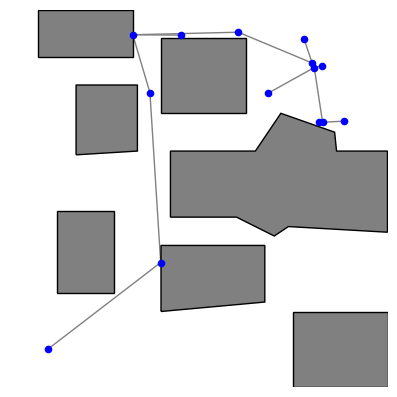

In [4]:
class RRT:
    def __init__(self, start, goal, map_dims, obstacles, bias, epsilon, max_iter):
        self.goal = goal
        self.start = start
        self.width = map_dims[0]
        self.height = map_dims[1]
        self.obstacles = obstacles
        self.bias = bias
        self.max_iter = max_iter
        self.epsilon = epsilon

        self.show_map(obs_set, map_dims)
        self.G = nx.Graph()
        self.G.add_node((start[0], start[1]))
        
        
    #Desenha o mapa com obstáculos
    def show_map(self, obs_set, map_dims):
        fig = plt.figure(figsize=(8,5), dpi=100)
        ax = fig.add_subplot(111, aspect='equal') 

        for obs in obs_set:
            ax.add_patch(PolygonPatch(obs, facecolor='gray'))
        
        ax.set_xlim(0, self.width)
        ax.set_ylim(0, self.height)
    
    #Amostra um ponto livre no mapa
    def sample_point(self):            
        x = random.uniform(1, self.width-1) #limitando pelo tamanho da parede
        y = random.uniform(1, self.height-1)
        p = Point([x,y])
        
        #se o ponto intercepta um obstáculo, retorna falso
        for o in self.obstacles:
            if p.intersects(o):
                return False, p
        return True, p
    
    #distância euclidiana
    def distance(self, p1, p2):
        px = (p1[0] - p2.x)**2
        py = (p1[1] - p2.y)**2
        return (px + py)**(0.5)
    
    #encontra o nó vizinho mais próximo à amostra fornecida
    def nearest_neighbor(self, sample):
        d = 1000
        n = self.G[start]
        for node in self.G:
            dist = self.distance(node, sample)
            if dist < d:
                d = dist
                n = node
        return d, n
    
    #expande o nó mais próximo em direção à amostra numa distancia fixa epsilon
    def expand_tree(self, n, d, sample):
        theta = math.asin((sample.y-n[1])/d)
        #x = n[0]+self.epsilon*np.cos(theta)
        #y = n[1]+self.epsilon*np.sin(theta)
        x = sample.x
        y = sample.y
        if x < 0:
            x = 0
        if x > self.width:
            x = self.width
        if y < 0:
            y = 0
        if y > self.height:
            y = self.height
        
        p = Point([x,y])
        node = Point([n[0], n[1]])
        line = LineString([p,n])
        for o in self.obstacles:
            if line.intersects(o):
                return x, y, False
        return x, y, True
    
        #for s in samples:
        #    print(s)
        #    plt.plot(*s[0].xy,'b*')
        
    #tenta fazer uma conexão direta do nó ao alvo
    def try_connect_goal(self, x, y):
        p = Point([x,y])
        g = Point([goal[0],goal[1]])
        line = LineString([p,g])
        for o in self.obstacles:
            if line.intersects(o):
                return False
        self.G.add_node((goal[0], goal[1]))
        self.G.add_edge((x,y),(goal[0], goal[1]))
        return True
    
    #executa rrt
    def run(self):
        i = 0
        path_found = False
        path=[]
        while i < self.max_iter and not path_found:
            is_sample_valid = False
            sample = (0,0)
            while not is_sample_valid:
                is_sample_valid, sample = self.sample_point();            
            sample = random.choices(population=[Point([goal[0],goal[1]]),sample],weights=[bias,1-bias])
            d, n = self.nearest_neighbor(sample[0])
            x, y, is_valid_connection = self.expand_tree(n, d, sample[0])
            if not is_valid_connection:
                continue
            self.G.add_node((x, y))
            self.G.add_edge(n, (x,y))
            
            path_found = self.try_connect_goal(x,y)
            if(path_found):
                print("Path has been found after ",i," iterations!")
                path = nx.shortest_path(self.G, source=(self.start[0], self.start[1]), target=(self.goal[0], self.goal[1]))
                
                pos = {node:(node[0], node[1]) for node in self.G.nodes()}
                #nx.draw_networkx_nodes(self.G, pos, nodelist=path, node_size=100, node_color='b')
                nx.draw(self.G, pos, font_size=3, with_labels=False, node_size=20, node_color='b', width=1, edge_color='gray')
                return path_found, path
            i=i+1
        print("Could not find path after ",i, " iterations.")
        pos = {node:(node[0], node[1]) for node in self.G.nodes()}
        #nx.draw_networkx_nodes(self.G, pos, nodelist=path, node_size=100, node_color='b')
        nx.draw(self.G, pos, font_size=3, with_labels=False, node_size=20, node_color='b', width=1, edge_color='gray')
        return path_found, path
            
#obstaculos caverna
obstacle1 = Polygon([(1.5,20),(1.5, 17.5),(6.5,17.5),(6.5,20)])
obstacle2 = Polygon([(8,18.5),(8,14.5),(12.5,14.5), (12.5,18.5)])
obstacle3 = Polygon([(20, 8.2),(14.75, 8.5),(14,8),(12,9),(8.5,9),(8.5,12.5),(13,12.5),(14.35,14.5),(17.2,13.5),(17.3,12.5),(20,12.5)])
obstacle4 = Polygon([(3.5,12.3),(3.5,16),(6.75,16),(6.75,12.5)])
obstacle5 = Polygon([(2.5,5),(2.5,9.3),(5.5,9.3),(5.5,5)])
obstacle6 = Polygon([(8,4),(8,7.5),(13.5,7.5),(13.5,4.5)])
obstacle7 = Polygon([(15,0),(15,4),(20,4),(20,0)])
obs_set = [obstacle1, obstacle2, obstacle3, obstacle4, obstacle5, obstacle6, obstacle7]



print ('Program started')
sim.simxFinish(-1) # just in case, close all opened connections
clientID=sim.simxStart('127.0.0.1',19999,True,True,5000,5) # Connect to CoppeliaSim

if clientID!=-1:
    print ('Connected to remote API server')

    robotname = 'robotino'
    returnCode, robotHandle = sim.simxGetObjectHandle(clientID, robotname, sim.simx_opmode_oneshot_wait)     
                 
    returnCode, wheel1 = sim.simxGetObjectHandle(clientID, 'wheel0_joint', sim.simx_opmode_oneshot_wait)
    returnCode, wheel2 = sim.simxGetObjectHandle(clientID, 'wheel1_joint', sim.simx_opmode_oneshot_wait)
    returnCode, wheel3 = sim.simxGetObjectHandle(clientID, 'wheel2_joint', sim.simx_opmode_oneshot_wait)
    
    # Robotino
    L = 0.135   # Metros
    r = 0.040   # Metros
    
    returnCode, pos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)        
    returnCode, ori = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
    
    robot_pos = (pos[0], pos[1])
    start = robot_pos
    goal = (2,2)
    map_dims = np.array([20, 20]) 
    
    
    bias = 0.05
    max_dist = 1.0
    max_iter = 1000
    rrt = RRT(start, goal, map_dims, obs_set, bias, max_dist, max_iter)
    found, path = rrt.run()
    print(path)
    if found:
        # Cinemática Direta
        Mdir = np.array([[-r/np.sqrt(3), 0, r/np.sqrt(3)], [r/3, (-2*r)/3, r/3], [r/(3*L), r/(3*L), r/(3*L)]])

        gain = np.array([[0.03, 0, 0], [0, 0.03, 0], [0, 0, 0.03]])

        print("Starting navigation to goal...")
        goal_reached = False
        for cell in path:
            qgoal = np.array([cell[0], cell[1], 0])
            print("qgoal: ",qgoal)
            cell_reached = False
            while not cell_reached:
                returnCode, pos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)        
                returnCode, ori = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
                q = np.array([pos[0], pos[1], ori[2]])
                #print("robotq: ",q)
                error = qgoal - q

                # Margem aceitável de distância
                if (np.linalg.norm(error[:2]) < 0.25):
                    cell_reached = True

                # Controller
                qdot = gain @ error

                # Cinemática Inversa
                # w1, w2, w3
                Minv = np.linalg.inv(Rz(q[2]) @ Mdir)
                u = Minv @ qdot

                # Enviando velocidades
                sim.simxSetJointTargetVelocity(clientID, wheel1, u[0], sim.simx_opmode_streaming)
                sim.simxSetJointTargetVelocity(clientID, wheel2, u[1], sim.simx_opmode_streaming)
                sim.simxSetJointTargetVelocity(clientID, wheel3, u[2], sim.simx_opmode_streaming)

            print("Cell ",cell," reached!")
            
    sim.simxSetJointTargetVelocity(clientID, wheel1, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, wheel2, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, wheel3, 0, sim.simx_opmode_oneshot_wait)
    
    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)
    
else:
    print('Failed connecting to remote API server')
    
    